In [1]:
import ssl

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)

        self.fc1 = nn.Linear(16*6*6,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's.weight

10
torch.Size([6, 1, 3, 3])


In [3]:
input = torch.randn(1,1,32,32)
out = net (input)
print(out)

tensor([[ 0.0298, -0.1267, -0.0669, -0.0433,  0.0380, -0.0887,  0.0278, -0.0150,
          0.0501, -0.0743]], grad_fn=<AddmmBackward0>)


In [4]:
net.zero_grad()
out.backward(torch.randn(1,10))

## Loss Function

In [5]:
output = net(input)
target = torch.randn(10)
target = target.view(1,-1)
criterion = nn.MSELoss()

loss = criterion(output,target)
print(loss)

tensor(1.2795, grad_fn=<MseLossBackward0>)


## Backprop

In [7]:
net.zero_grad()
print("conv1.bias.grad before backward")
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0032,  0.0057, -0.0019,  0.0047, -0.0039,  0.0006])


## Update the weights

In [9]:
# weight = weight - learning_rate*gradient
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*learning_rate)

import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output,target)
loss.backward()
optimizer.step() # do the update

## Exercise 1



In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl

In [21]:
ssl._create_default_https_context = ssl._create_unverified_context
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


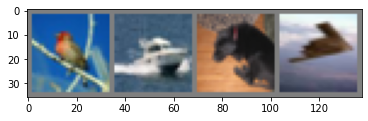

 bird  ship   dog plane


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## change the lr =0.001

[1,  2000] loss: 2.251
[1,  4000] loss: 1.888
[1,  6000] loss: 1.706
[1,  8000] loss: 1.614
[1, 10000] loss: 1.536
[1, 12000] loss: 1.483
[2,  2000] loss: 1.399
[2,  4000] loss: 1.370
[2,  6000] loss: 1.369
[2,  8000] loss: 1.306
[2, 10000] loss: 1.319
[2, 12000] loss: 1.305
Finished Training


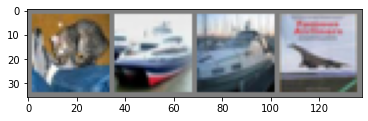

GroundTruth:    cat  ship  ship plane
Predicted:   bird   car plane plane


In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


## change lr = 0.01

[1,  2000] loss: 1.922
[1,  4000] loss: 1.922
[1,  6000] loss: 1.945
[1,  8000] loss: 1.974
[1, 10000] loss: 1.959
[1, 12000] loss: 1.967
[2,  2000] loss: 1.975
[2,  4000] loss: 1.966
[2,  6000] loss: 1.978
[2,  8000] loss: 2.017
[2, 10000] loss: 2.019
[2, 12000] loss: 2.015
Finished Training


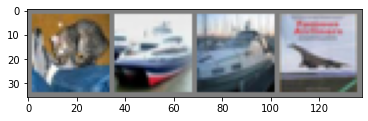

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship  ship


In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

when we chage the parameter lr form 0.001 to 0.01, we can see that the accuracy **goes up**.


## Question
(1) Can neural networks be used for unsupervised clustering or data
dimension reduction? Why?
(2)What are the strengths of neural networks; when do they perform well?
(3) What are the weaknesses of neural networks; when do they perform poorly?
(4) What makes neural networks a good candidate for the classification /
regression problem, if you have enough knowledge about the data?

Question1:
Yes, **An auto-encoder** is a kind of unsupervised neural network that is used for dimensionality reduction and feature discovery.

Question2:
* Neural Networks have the ability to learn by themselves and produce the output that is not limited to the input provided to them.
* The input is stored in its own networks instead of a database, hence the loss of data does not affect its working.
* These networks can learn from examples and apply them when a similar event arises, making them able to work through real-time events.
* Even if a neuron is not responding or a piece of information is missing, the network can detect the fault and still produce the output.
* They can perform multiple tasks in parallel without affecting the system performance.
When the dataset is large,it perform well

Question3:
* Hardware Dependence
* Unexplained functioning of the network
* Assurance of proper network structure
* The duration of the network is unknown
Limited by the limitations of current training methods, many times the network layer becomes more, but the performance is not good

Question4:
When the dataset is large, especially when dealing with large images